# Reinforcement Learning

This Jupyter notebook acts as supporting material for **Chapter 21 Reinforcement Learning** of the book* Artificial Intelligence: A Modern Approach*. This notebook makes use of the implementations in `rl.py` module. We also make use of implementation of MDPs in the `mdp.py` module to test our agents. It might be helpful if you have already gone through the Jupyter notebook dealing with Markov decision process. Let us import everything from the `rl` module. It might be helpful to view the source of some of our implementations. Please refer to the Introductory Jupyter notebook for more details.

In [101]:
from reinforcement_learning4e import *

## CONTENTS

* Overview
* Passive Reinforcement Learning
    - Direct Utility Estimation
    - Adaptive Dynamic Programming
    - Temporal-Difference Agent
* Active Reinforcement Learning
    - Q learning

## OVERVIEW

Before we start playing with the actual implementations let us review a couple of things about RL.

1. Reinforcement Learning is concerned with how software agents ought to take actions in an environment so as to maximize some notion of cumulative reward. 

2. Reinforcement learning differs from standard supervised learning in that correct input/output pairs are never presented, nor sub-optimal actions explicitly corrected. Further, there is a focus on on-line performance, which involves finding a balance between exploration (of uncharted territory) and exploitation (of current knowledge).

-- Source: [Wikipedia](https://en.wikipedia.org/wiki/Reinforcement_learning)

In summary we have a sequence of state action transitions with rewards associated with some states. Our goal is to find the optimal policy $\pi$ which tells us what action to take in each state.

## PASSIVE REINFORCEMENT LEARNING

In passive Reinforcement Learning the agent follows a fixed policy $\pi$. Passive learning attempts to evaluate the given policy $pi$ - without any knowledge of the Reward function $R(s)$ and the Transition model $P(s'\ |\ s, a)$.

This is usually done by some method of **utility estimation**. The agent attempts to directly learn the utility of each state that would result from following the policy. Note that at each step, it has to *perceive* the reward and the state - it has no global knowledge of these. Thus, if a certain the entire set of actions offers a very low probability of attaining some state $s_+$ - the agent may never perceive the reward $R(s_+)$.

Consider a situation where an agent is given a policy to follow. Thus, at any point it knows only its current state and current reward, and the action it must take next. This action may lead it to more than one state, with different probabilities.

For a series of actions given by $\pi$, the estimated utility $U$:
$$U^{\pi}(s) = E(\sum_{t=0}^\inf \gamma^t R^t(s')$$)
Or the expected value of summed discounted rewards until termination.

Based on this concept, we discuss three methods of estimating utility:

1. **Direct Utility Estimation (DUE)**
 
 The first, most naive method of estimating utility comes from the simplest interpretation of the above definition. We construct an agent that follows the policy until it reaches the terminal state. At each step, it logs its current state, reward. Once it reaches the terminal state, it can estimate the utility for each state for *that* iteration, by simply summing the discounted rewards from that state to the terminal one.

 It can now run this 'simulation' $n$ times, and calculate the average utility of each state. If a state occurs more than once in a simulation, both its utility values are counted separately.
 
 Note that this method may be prohibitively slow for very large statespaces. Besides, **it pays no attention to the transition probability $P(s'\ |\ s, a)$.** It misses out on information that it is capable of collecting (say, by recording the number of times an action from one state led to another state). The next method addresses this issue.
 
2. **Adaptive Dynamic Programming (ADP)**
 
 This method makes use of knowledge of the past state $s$, the action $a$, and the new perceived state $s'$ to estimate the transition probability $P(s'\ |\ s,a)$. It does this by the simple counting of new states resulting from previous states and actions.<br> 
 The program runs through the policy a number of times, keeping track of:
    - each occurrence of state $s$ and the policy-recommended action $a$ in $N_{sa}$
    - each occurrence of $s'$ resulting from $a$ on $s$ in $N_{s'|sa}$.
     
 It can thus estimate $P(s'\ |\ s,a)$ as $N_{s'|sa}/N_{sa}$, which in the limit of infinite trials, will converge to the true value.<br>
 Using the transition probabilities thus estimated, it can apply `POLICY-EVALUATION` to estimate the utilities $U(s)$ using properties of convergence of the Bellman functions.

3. **Temporal-difference learning (TD)**
 
 Instead of explicitly building the transition model $P$, the temporal-difference model makes use of the expected closeness between the utilities of two consecutive states $s$ and $s'$.
 For the transition $s$ to $s'$, the update is written as:
$$U^{\pi}(s) \leftarrow U^{\pi}(s) + \alpha \left( R(s) + \gamma U^{\pi}(s') - U^{\pi}(s) \right)$$
 This model implicitly incorporates the transition probabilities by being weighed for each state by the number of times it is achieved from the current state. Thus, over a number of iterations, it converges similarly to the Bellman equations.
 The advantage of the TD learning model is its relatively simple computation at each step, rather than having to keep track of various counts.
 For $n_s$ states and $n_a$ actions the ADP model would have $n_s \times n_a$ numbers $N_{sa}$ and $n_s^2 \times n_a$ numbers $N_{s'|sa}$ to keep track of. The TD model must only keep track of a utility $U(s)$ for each state.

#### Demonstrating Passive agents

Passive agents are implemented in `rl.py` as various `Agent-Class`es.

To demonstrate these agents, we make use of the `GridMDP` object from the `MDP` module. `sequential_decision_environment` is similar to that used for the `MDP` notebook but has discounting with $\gamma = 0.9$.

The `Agent-Program` can be obtained by creating an instance of the relevant `Agent-Class`. The `__call__` method allows the `Agent-Class` to be called as a function. The class needs to be instantiated with a policy ($\pi$) and an `MDP` whose utility of states will be estimated.

In [102]:
from mdp4e import sequential_decision_environment

The `sequential_decision_environment` is a GridMDP object as shown below. The rewards are **+1** and **-1** in the terminal states, and **-0.04** in the rest. <img src="files/images/mdp.png"> Now we define actions and a policy similar to **Fig 21.1** in the book.

In [103]:
# Action Directions
north = (0, 1)
south = (0,-1)
west = (-1, 0)
east = (1, 0)

# policy = {
#     (0, 2): east, (1, 2): east,  (2, 2): east,   (3, 2): None,
#     (0, 1): north,               (2, 1): north,    (3, 1): None,
#     (0, 0): north, (1, 0): west,                   (3, 0): north, 
# }

policy = {
    (0, 7): east,  (1, 7): east,  (2, 7): east,   (3, 7): east, (4, 7): east,  (5, 7): east,  (6, 7): east,   (7, 7): None,
    (0, 6): north, (1, 6): north, (2, 6): north,  (3, 6): north, (4, 6): east,  (5, 6): east,  (6, 6): east,   (7, 6): north,
    (0, 5): north, (1, 5): north,  (2, 5): west,   (3, 5): west, (4, 5): east,  (5, 5): north, (6, 5): east,    (7, 5): north,
    (0, 4): north, (1, 4): north, (2, 4): north,  (3, 4): north,                                               (7, 4): north,
    (0, 3): north, (1, 3): north, (2, 3): north,  (3, 3): north, (4, 3): east,  (5, 3): east,  (6, 3): east,   (7, 3): north,
    (0, 2): north, (1, 2): north, (2, 2): north,   (3, 2): west, (4, 2): east,  (5, 2): east,  (6, 2): east,   (7, 2): north,
    (0, 1): east, (1, 1): east, (2, 1): north,   (3, 1): east,  (4, 1): east,  (5, 1): east,  (6, 1): east,   (7, 1): north,
    (0, 0): east, (1, 0): east,  (2, 0): east,   (3, 0): east, (4, 0): east,  (5, 0): east,  (6, 0): east,   (7, 0): north
}



###  Direction Utility Estimation Agent

The `PassiveDEUAgent` class in the `rl` module implements the Agent Program described in **Fig 21.2** of the AIMA Book. `PassiveDEUAgent` sums over rewards to find the estimated utility for each state. It thus requires the running of a number of iterations.

In [104]:
%psource PassiveDUEAgent

class PassiveDUEAgent:
    """
    Passive (non-learning) agent that uses direct utility estimation
    on a given MDP and policy.

    import sys
    from mdp import sequential_decision_environment
    north = (0, 1)
    south = (0,-1)
    west = (-1, 0)
    east = (1, 0)
    policy = {(0, 2): east, (1, 2): east, (2, 2): east, (3, 2): None, (0, 1): north, (2, 1): north,
              (3, 1): None, (0, 0): north, (1, 0): west, (2, 0): west, (3, 0): west,}
    agent = PassiveDUEAgent(policy, sequential_decision_environment)
    for i in range(200):
        run_single_trial(agent,sequential_decision_environment)
        agent.estimate_U()
    agent.U[(0, 0)] > 0.2
    True
    """

    def __init__(self, pi, mdp):
        self.pi = pi
        self.mdp = mdp
        self.U = {}
        self.s = None
        self.a = None
        self.s_history = []
        self.r_history = []
        self.init = mdp.init

    def __call__(self, percept):
        s1, r1 = percept
        self.s_history.app

In [105]:
DUEagent = PassiveDUEAgent(policy, sequential_decision_environment)
for i in range(1000):
    run_single_trial(DUEagent, sequential_decision_environment)
    DUEagent.estimate_U()



The calculated utilities are:

In [106]:
print('\n'.join([str(k)+':'+str(v) for k, v in DUEagent.U.items()]))

(7, 4):-3.68445816478141
(4, 0):-8.242804181826422
(7, 1):-7.439082388829168
(7, 7):10.0
(6, 5):9.044490591880303
(0, 0):-8.379597076754223
(6, 1):-3.4244806508907817
(7, 0):-7.637610142926445
(2, 0):-8.161665537252677
(3, 0):-8.121580802042345
(7, 3):-7.330553898429667
(7, 6):9.959597943623109
(5, 0):-9.016138843197512
(7, 2):-7.449023214683534
(6, 0):-8.948805552897648
(1, 0):-8.206688512566645
(7, 5):8.926233085980463
(3, 7):9.822609171422284
(5, 7):9.91352527050985
(0, 5):9.504632625617088
(2, 2):-2.7651368162022796
(1, 6):8.686642655868884
(2, 5):-2.3407995129560617
(2, 4):-3.2790394387086756
(2, 1):-2.8052317482901508
(2, 7):9.521972794081718
(1, 5):7.685132725118413
(6, 7):9.959999799726067
(4, 7):9.863392890252129
(0, 6):9.544978559839155
(2, 3):-2.7592987596306906
(1, 7):9.71252241520818
(6, 6):9.916132807633652
(1, 1):-0.15431776089956128
(6, 2):-5.854158418367646
(6, 3):-3.8484021573105625
(2, 6):8.509033487458847
(4, 6):9.754774688482284
(5, 6):9.85968623874258
(5, 1):-3.80

### Adaptive Dynamic Programming Agent

The `PassiveADPAgent` class in the `rl` module implements the Agent Program described in **Fig 21.2** of the AIMA Book. `PassiveADPAgent` uses state transition and occurrence counts to estimate $P$, and then $U$. Go through the source below to understand the agent.

In [107]:
%psource PassiveADPAgent

class PassiveADPAgent:
    """
    [Figure 21.2]
    Passive (non-learning) agent that uses adaptive dynamic programming
    on a given MDP and policy.

    import sys
    from mdp import sequential_decision_environment
    north = (0, 1)
    south = (0,-1)
    west = (-1, 0)
    east = (1, 0)
    policy = {(0, 2): east, (1, 2): east, (2, 2): east, (3, 2): None, (0, 1): north, (2, 1): north,
              (3, 1): None, (0, 0): north, (1, 0): west, (2, 0): west, (3, 0): west,}
    agent = PassiveADPAgent(policy, sequential_decision_environment)
    for i in range(100):
        run_single_trial(agent,sequential_decision_environment)

    agent.U[(0, 0)] > 0.2
    True
    agent.U[(0, 1)] > 0.2
    True
    """

    class ModelMDP(MDP):
        """Class for implementing modified Version of input MDP with
        an editable transition model P and a custom function T."""

        def __init__(self, init, actlist, terminals, gamma, states):
            super().__init__(init, actlist, termin

We instantiate a `PassiveADPAgent` below with the `GridMDP` shown and train it over 200 iterations. The `rl` module has a simple implementation to simulate iterations. The function is called **run_single_trial**.

In [108]:
ADPagent = PassiveADPAgent(policy, sequential_decision_environment)
for i in range(200):
    run_single_trial(ADPagent, sequential_decision_environment)

The calculated utilities are:

In [ ]:
print('\n'.join([str(k)+':'+str(v) for k, v in ADPagent.U.items()]))

(0, 0):-2.7298817953474193
(4, 0):-3.4517194470187684
(3, 4):-0.9400000000000001
(4, 3):-5.592714725066126
(3, 1):-4.319822932305736
(3, 7):5.438441868127796
(4, 6):5.642090853269927
(5, 1):-5.596927891194049
(5, 7):7.3168021923224975
(0, 2):-10.0
(0, 5):2.4145106595552646
(2, 2):-4.924468554066622
(1, 0):-2.8239739509703212
(1, 6):3.1570692380183596
(2, 5):-9.692486201754793
(1, 3):-0.08289732994938578
(7, 4):-5.9855887635099965
(6, 2):-5.970086801004628
(7, 1):-4.9968809522058315
(7, 7):10.0
(6, 5):5.5585720406806205
(4, 2):-9.008360813139879
(3, 0):-3.225432010667912
(4, 5):5.037881767942935
(3, 3):-1.583907208759919
(5, 0):-3.688084723177215
(5, 6):6.5850173177601246
(3, 6):4.900418702971996
(5, 3):-6.169683027842709
(0, 1):-4.560561511839428
(0, 7):3.087251555275052
(2, 4):-8.487355668633054
(1, 2):-3.6247197121103194
(0, 4):2.133059593599738
(2, 1):-4.285944114087199
(2, 7):4.60076297164126
(1, 5):1.2140339749133124
(6, 1):-4.56089870782727
(7, 0):-4.370037688478144
(7, 3):-6.397

### Passive Temporal Difference Agent

`PassiveTDAgent` uses temporal differences to learn utility estimates. We learn the difference between the states and backup the values to previous states.  Let us look into the source before we see some usage examples.

In [ ]:
%psource PassiveTDAgent

class PassiveTDAgent:
    """
    [Figure 21.4]
    The abstract class for a Passive (non-learning) agent that uses
    temporal differences to learn utility estimates. Override update_state
    method to convert percept to state and reward. The mdp being provided
    should be an instance of a subclass of the MDP Class.

    import sys
    from mdp import sequential_decision_environment
    north = (0, 1)
    south = (0,-1)
    west = (-1, 0)
    east = (1, 0)
    policy = {(0, 2): east, (1, 2): east, (2, 2): east, (3, 2): None, (0, 1): north, (2, 1): north,
              (3, 1): None, (0, 0): north, (1, 0): west, (2, 0): west, (3, 0): west,}
    agent = PassiveTDAgent(policy, sequential_decision_environment, alpha=lambda n: 60./(59+n))
    for i in range(200):
        run_single_trial(agent,sequential_decision_environment)

    agent.U[(0, 0)] > 0.2
    True
    agent.U[(0, 1)] > 0.2
    True
    """

    def __init__(self, pi, mdp, alpha=None):

        self.pi = pi
        self.U =

In creating the `TDAgent`, we use the **same learning rate** $\alpha$ as given in the footnote of the book on **page 837**.

In [ ]:
TDagent = PassiveTDAgent(policy, sequential_decision_environment, alpha = lambda n: 60./(59+n))

Now we run **200 trials** for the agent to estimate Utilities.

In [ ]:
for i in range(200):
    run_single_trial(TDagent,sequential_decision_environment)

The calculated utilities are:

In [ ]:
print('\n'.join([str(k)+':'+str(v) for k, v in TDagent.U.items()]))

(4, 0):-3.8454502930340495
(3, 4):-0.9393965998882593
(4, 3):-4.911164248158563
(3, 1):-4.920910539148444
(3, 7):4.6673866326548525
(4, 6):5.76962866908318
(5, 1):-4.835793796699703
(5, 7):6.916248428472059
(0, 2):-10
(0, 5):2.6379092053701143
(2, 2):-4.199387237136291
(1, 0):-3.377013220342686
(1, 6):3.930938195490529
(2, 5):-8.32146246607162
(1, 3):0.7513281754248284
(7, 4):-7.106405678715151
(6, 2):-5.566068442072144
(7, 1):-5.354256748403494
(7, 7):10
(6, 5):5.34060587137639
(4, 2):-10.0
(3, 0):-3.492665432094761
(4, 5):-0.07600000000000001
(3, 3):-0.848536312031463
(5, 0):-3.83158901947671
(5, 6):5.8586328071009985
(3, 6):4.8762246668103435
(5, 3):-6.843624431363199
(0, 1):-8.271002746127358
(0, 7):4.060441169426265
(2, 4):-8.560900321727217
(1, 2):-5.439839446577694
(0, 4):2.0862857246217548
(2, 1):-2.1127657625066427
(2, 7):4.555070272158578
(1, 5):2.228414129368392
(6, 1):-4.8543117798260855
(7, 0):-4.719827768270907
(7, 3):-6.544447989838503
(6, 7):8.959096527439822
(7, 6):8.3

## Comparison with value iteration method

We can also compare the utility estimates learned by our agent to those obtained via **value iteration**.

**Note that value iteration has a priori knowledge of the transition table $P$, the rewards $R$, and all the states $s$.**

In [ ]:
from mdp4e import value_iteration

The values calculated by value iteration:

In [ ]:
U_values = value_iteration(sequential_decision_environment)
print('\n'.join([str(k)+':'+str(v) for k, v in U_values.items()]))

(4, 0):0.20613401404876092
(3, 4):0.5027823798502125
(4, 3):0.4610575123374177
(3, 1):0.3890609707415478
(3, 7):5.4768043075879635
(4, 6):5.7140678387889325
(5, 1):-0.9808577365113227
(5, 7):7.419331860809735
(0, 2):-10
(0, 5):2.3882093486949305
(2, 2):0.6277953174566747
(1, 0):0.26147733558027636
(1, 6):3.3139422080663548
(2, 5):-7.807981569055003
(1, 3):1.266195840691091
(7, 4):-6.615198954253358
(6, 2):-1.3214139727971803
(7, 1):-0.13331442187882087
(7, 7):10
(6, 5):6.466073568420779
(4, 2):-0.5720032829935289
(3, 0):0.2901870316096985
(4, 5):5.047704330354068
(3, 3):0.7097815079375986
(5, 0):0.022130415536142527
(5, 6):6.561871328704624
(3, 6):4.689724230968557
(5, 3):-1.7231194166079322
(0, 1):-1.0215163320369014
(0, 7):3.3426188835734703
(2, 4):-0.15011867142821966
(1, 2):-0.4081752711255061
(0, 4):2.006145384148317
(2, 1):0.4728825757574549
(2, 7):4.588415522502781
(1, 5):1.1638470983220925
(6, 1):-0.17153477862006347
(7, 0):-0.09149206028607111
(7, 3):-1.4351416381525968
(6, 7)

## Evolution of utility estimates over iterations

We can explore how these estimates vary with time by using plots similar to **Fig 21.5a**. We will first enable matplotlib using the inline backend. We also define a function to collect the values of utilities at each iteration.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

def graph_utility_estimates(agent_program, mdp, no_of_iterations, states_to_graph):
    graphs = {state:[] for state in states_to_graph}
    for iteration in range(1,no_of_iterations+1):
        run_single_trial(agent_program, mdp)
        for state in states_to_graph:
            graphs[state].append((iteration, agent_program.U[state]))
    for state, value in graphs.items():
        state_x, state_y = zip(*value)
        plt.plot(state_x, state_y, label=str(state))
#     plt.ylim([0,1.2])
    plt.legend(loc='lower right')
    plt.xlabel('Iterations')
    plt.ylabel('U')

Here is a plot of state $(2,2)$.

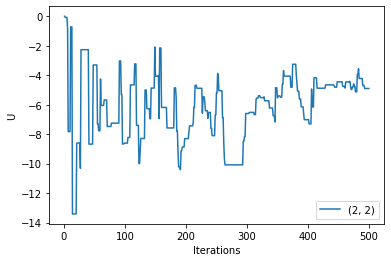

In [ ]:
agent = PassiveTDAgent(policy, sequential_decision_environment, alpha=lambda n: 60./(59+n))
graph_utility_estimates(agent, sequential_decision_environment, 500, [(2,2)])

It is also possible to plot multiple states on the same plot. As expected, the utility of the finite state $(3,2)$ stays constant and is equal to $R((3,2)) = 1$.

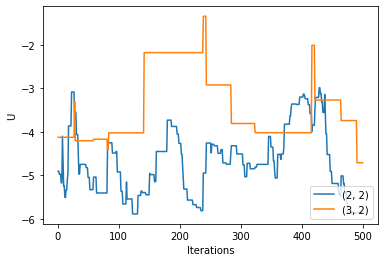

In [ ]:
graph_utility_estimates(agent, sequential_decision_environment, 500, [(2,2), (3,2)])

## ACTIVE REINFORCEMENT LEARNING

Unlike Passive Reinforcement Learning in Active Reinforcement Learning we are not bound by a policy pi and we need to select our actions. In other words the agent needs to learn an optimal policy. The fundamental tradeoff the agent needs to face is that of exploration vs. exploitation. 

### QLearning Agent

The QLearningAgent class in the rl module implements the Agent Program described in **Fig 21.8** of the AIMA Book. In Q-Learning the agent learns an action-value function Q which gives the utility of taking a given action in a particular state. Q-Learning does not required a transition model and hence is a model free method. Let us look into the source before we see some usage examples.

In [ ]:
%psource QLearningAgent

class QLearningAgent:
    """
    [Figure 21.8]
    An exploratory Q-learning agent. It avoids having to learn the transition
    model because the Q-value of a state can be related directly to those of
    its neighbors.

    import sys
    from mdp import sequential_decision_environment
    north = (0, 1)
    south = (0,-1)
    west = (-1, 0)
    east = (1, 0)
    policy = {(0, 2): east, (1, 2): east, (2, 2): east, (3, 2): None, (0, 1): north, (2, 1): north,
              (3, 1): None, (0, 0): north, (1, 0): west, (2, 0): west, (3, 0): west,}
    q_agent = QLearningAgent(sequential_decision_environment, Ne=5, Rplus=2, alpha=lambda n: 60./(59+n))
    for i in range(200):
        run_single_trial(q_agent,sequential_decision_environment)

    q_agent.Q[((0, 1), (0, 1))] >= -0.5
    True
    q_agent.Q[((1, 0), (0, -1))] <= 0.5
    True
    """

    def __init__(self, mdp, Ne, Rplus, alpha=None):

        self.gamma = mdp.gamma
        self.terminals = mdp.terminals
        self.all_act =

The Agent Program can be obtained by creating the instance of the class by passing the appropriate parameters. Because of the __ call __ method the object that is created behaves like a callable and returns an appropriate action as most Agent Programs do. To instantiate the object we need a mdp similar to the PassiveTDAgent.

 Let us use the same GridMDP object we used above. **Figure 17.1 (sequential_decision_environment)** is similar to **Figure 21.1** but has some discounting as **gamma = 0.9**. The class also implements an exploration function **f** which returns fixed **Rplus** until agent has visited state, action **Ne** number of times. This is the same as the one defined on page **842** of the book. The method **actions_in_state** returns actions possible in given state. It is useful when applying max and argmax operations.

Let us create our object now. We also use the **same alpha** as given in the footnote of the book on **page 837**. We use **Rplus = 2** and **Ne = 5** as defined on page 843. **Fig 21.7**  

In [ ]:
q_agent = QLearningAgent(sequential_decision_environment, Ne=5, Rplus=2, 
                         alpha=lambda n: 60./(59+n))

Now to try out the q_agent we make use of the **run_single_trial** function in rl.py (which was also used above). Let us use **200** iterations.

In [ ]:
for i in range(100):
    run_single_trial(q_agent,sequential_decision_environment)

Now let us see the Q Values. The keys are state-action pairs. Where different actions correspond according to:

north = (0, 1)
south = (0,-1)
west = (-1, 0)
east = (1, 0)

In [ ]:
q_agent.Q

defaultdict(float,
            {((0, 0), (1, 0)): -0.667401172925876,
             ((0, 0), (0, 1)): -0.8341176470588235,
             ((0, 0), (-1, 0)): -0.7767134674785574,
             ((0, 0), (0, -1)): -0.30841458638936003,
             ((1, 0), (1, 0)): -0.2271968693628458,
             ((1, 0), (0, 1)): -0.22782697496043106,
             ((1, 0), (-1, 0)): -0.26230401371502354,
             ((1, 0), (0, -1)): -0.3028849034884784,
             ((2, 0), (1, 0)): -0.22816279470758058,
             ((2, 0), (0, 1)): -0.23009801353244097,
             ((2, 0), (-1, 0)): -0.23332201144278913,
             ((2, 0), (0, -1)): -0.22832647294232244,
             ((3, 0), (1, 0)): -0.21995571985029946,
             ((3, 0), (0, 1)): -0.23032116219212487,
             ((3, 0), (-1, 0)): -0.22850564641526055,
             ((3, 0), (0, -1)): -0.2273605237669046,
             ((4, 0), (1, 0)): -0.2287377576721529,
             ((4, 0), (0, 1)): -0.2216801312159856,
             ((4, 0), (-1, 0

The Utility **U** of each state is related to **Q** by the following equation.

**U (s) = max <sub>a</sub> Q(s, a)**

Let us convert the Q Values above into U estimates.



In [ ]:
U = defaultdict(lambda: -1000.) # Very Large Negative Value for Comparison see below.
for state_action, value in q_agent.Q.items():
    state, action = state_action
    if U[state] < value:
                U[state] = value

In [ ]:
U

defaultdict(<function __main__.<lambda>()>,
            {(0, 0): -0.30841458638936003,
             (1, 0): -0.2271968693628458,
             (2, 0): -0.22816279470758058,
             (3, 0): -0.21995571985029946,
             (4, 0): -0.2216801312159856,
             (5, 0): -0.2591750285130355,
             (6, 0): -0.2383909217528491,
             (7, 0): -0.2523620481865066,
             (7, 1): -0.13594879921985684,
             (7, 2): -0.04716077702748215,
             (7, 3): -1.1676777426636622,
             (7, 4): -9.983329386905647,
             (7, 5): 7.012782258064518,
             (6, 5): 0.0,
             (7, 6): 8.959135944700462,
             (7, 7): 10,
             (2, 1): -0.23208654985933574,
             (3, 1): -0.2269138502894415,
             (4, 1): -0.2404378189841548,
             (5, 1): -1.2162956617608365,
             (6, 1): -0.24069113675758294,
             (6, 2): 0.0,
             (0, 1): -1.194651611351931,
             (1, 1): -0.22871961743136

Let us finally compare these estimates to value_iteration results.

In [ ]:
print(value_iteration(sequential_decision_environment))

{(4, 0): 0.20613401404876092, (3, 4): 0.5027823798502125, (4, 3): 0.4610575123374177, (3, 1): 0.3890609707415478, (3, 7): 5.4768043075879635, (4, 6): 5.7140678387889325, (5, 1): -0.9808577365113227, (5, 7): 7.419331860809735, (0, 2): -10, (0, 5): 2.3882093486949305, (2, 2): 0.6277953174566747, (1, 0): 0.26147733558027636, (1, 6): 3.3139422080663548, (2, 5): -7.807981569055003, (1, 3): 1.266195840691091, (7, 4): -6.615198954253358, (6, 2): -1.3214139727971803, (7, 1): -0.13331442187882087, (7, 7): 10, (6, 5): 6.466073568420779, (4, 2): -0.5720032829935289, (3, 0): 0.2901870316096985, (4, 5): 5.047704330354068, (3, 3): 0.7097815079375986, (5, 0): 0.022130415536142527, (5, 6): 6.561871328704624, (3, 6): 4.689724230968557, (5, 3): -1.7231194166079322, (0, 1): -1.0215163320369014, (0, 7): 3.3426188835734703, (2, 4): -0.15011867142821966, (1, 2): -0.4081752711255061, (0, 4): 2.006145384148317, (2, 1): 0.4728825757574549, (2, 7): 4.588415522502781, (1, 5): 1.1638470983220925, (6, 1): -0.17153